# Implementing a CGAN for the Wine data set to generate synthetic data
### Import necessary modules and packages

In [1]:
import os
while os.path.basename(os.getcwd()) != 'Synthetic_Data_GAN_Capstone':
    os.chdir('..')
from scripts.Utils.utils import *
safe_mkdir('experiments')
from scripts.Utils.data_loading import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from models.CGAN_wine import CGAN_Generator, CGAN_Discriminator
import random

### Set random seem for reproducibility

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Import and briefly inspect data

In [3]:
wine = load_dataset('wine')
wine.head()

,class,alcohol,malic_acid,ash,alkalinity,magnesium,phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,dilution,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### Preprocessing data
This data set is more complicated than the iris data set, in that we have far more features and thus a larger and more complex space to explore. As a result, the primary architectural difference made was to increase the depth of the generator network. Here I split the data roughly 50/50 so we can demonstrate the effectiveness of additional data. Used a train set size of 90 to allow for 30 of each class.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(wine.drop(columns='class'), wine['class'], test_size=88, stratify=wine['class'], random_state=manualSeed)
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

x_train: (90, 13)
x_test: (88, 13)


### Model parameters (feel free to play with these)

In [5]:
nz = 64  # Size of generator noise input
H = 32  # Size of hidden network layer
out_dim = x_train.shape[1]  # Size of output
bs = x_train.shape[0]  # Full data set
nc = 3  # 3 different types of label in this problem
num_batches = 1
num_epochs = 10000
print_interval = 1000
exp_name = 'experiments/wine_1x32_wd_0'
safe_mkdir(exp_name)

### Adam optimizer hyperparameters

In [6]:
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

### Set the device
Utilizing cpu due to the small data set and having 16 cores on my cpu actually results in faster training on the cpu.

In [7]:
device = 'cpu'

### Scale inputs

In [8]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_train_tensor = torch.tensor(x_train, dtype=torch.float)
y_train_dummies = pd.get_dummies(y_train)
y_train_dummies_tensor = torch.tensor(y_train_dummies.values, dtype=torch.float)

### Instantiate nets

In [9]:
netG = CGAN_Generator(nz=nz, H=H, out_dim=out_dim, nc=nc, bs=bs, device=device, wd=0).to(device)
netD = CGAN_Discriminator(H=H, out_dim=out_dim, nc=nc, device=device, wd=0).to(device)

### Print models

In [10]:
print(netG)
print(netD)

CGAN_Generator(
  (fc1): Linear(in_features=67, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=13, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (loss_fn): BCELoss()
)
CGAN_Discriminator(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.2)
  (m): Sigmoid()
  (loss_fn): BCELoss()
)


### Define labels

In [11]:
real_label = 1
fake_label = 0

### Train on real data
First, we will train a model on the real training data in order to develop a benchmark against which to compare models trained on fake data. This will allow us to estimate the performance of our GAN in an unbiased manner.

In [12]:
y_test_dummies = pd.get_dummies(y_test)
print("Dummy columns match?", all(y_train_dummies.columns == y_test_dummies.columns))
x_test = scaler.transform(x_test)
labels_list = [x for x in y_train_dummies.columns]
param_grid = {'tol': [1e-9],
              'C': [0.5],
              'l1_ratio': [0]}
model_real, score_real = train_test_logistic_reg(x_train, y_train, x_test, y_test, param_grid=param_grid, cv=5, random_state=manualSeed, labels=labels_list)
print("Model trained on real data achieved an accuracy score of {0:.2f}".format(score_real))

Dummy columns match? True
Accuracy: 0.9772727272727273
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-09}
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        29
           2       0.97      0.97      0.97        35
           3       1.00      0.96      0.98        24

    accuracy                           0.98        88
   macro avg       0.98      0.98      0.98        88
weighted avg       0.98      0.98      0.98        88

[[29  0  0]
 [ 1 34  0]
 [ 0  1 23]]
Model trained on real data achieved an accuracy score of 0.98


Looks like we achieved 97.7% accuracy, with only two incorrect predictions. This is clearly a very easy data set, but can we do better using fake generated data?

## Training the GAN
First, let's preallocate some objects for storing training results as we train our GAN. The test_range object represents the various fake data set sizes that we will generate and train our model on in order to compare to our baseline. Remember that our baseline was trained on a data set of size 90.

In [13]:
test_range = [90, 180, 360, 720, 1440]
stored_models = []
stored_scores = []
best_score = 0

Now we can train our model:

In [14]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i in range(num_batches):  # Only one batch per epoch since our data is horrifically small
        # Update Discriminator
        # All real batch first
        real_data = x_train_tensor.to(device)  # Format batch (entire data set in this case)
        real_classes = y_train_dummies_tensor.to(device)
        label = torch.full((bs,), real_label, device=device)  # All real labels

        output = netD(real_data, real_classes).view(-1)  # Forward pass with real data through Discriminator
        netD.train_one_step_real(output, label)

        # All fake batch next
        noise = torch.randn(bs, nz, device=device)  # Generate batch of latent vectors
        fake = netG(noise, real_classes)  # Fake image batch with netG
        label.fill_(fake_label)
        output = netD(fake.detach(), real_classes).view(-1)
        netD.train_one_step_fake(output, label)
        netD.combine_and_update_opt()
        netD.update_history()

        # Update Generator
        label.fill_(real_label)  # Reverse labels, fakes are real for generator cost
        output = netD(fake, real_classes).view(-1)  # Since D has been updated, perform another forward pass of all-fakes through D
        netG.train_one_step(output, label)
        netG.update_history()

    # Output training stats
    if epoch % print_interval == 0 or (epoch == num_epochs-1):
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch+1, num_epochs, netD.loss.item(), netG.loss.item(), netD.D_x, netD.D_G_z1, netG.D_G_z2))
        with torch.no_grad():
            # Generate various levels of amounts of fake data and test how training compares
            tmp_models, tmp_scores = evaluate_training_progress(test_range=test_range, fake_bs=bs, nz=nz, nc=nc, out_dim=out_dim, netG=netG,
                                                                x_test=x_test, y_test=y_test, manualSeed=manualSeed, labels_list=labels_list,
                                                                param_grid=param_grid, device=device)
        if max(tmp_scores) > best_score:
            best_score = max(tmp_scores)
            torch.save(netG.state_dict(), exp_name + "/best_netG.pt")
        stored_models += tmp_models
        stored_scores += tmp_scores

print("Real data best score:", score_real)
print("GAN best score:", best_score)
if best_score > score_real:
    print("Success! GAN beat real data!")
else:
    print("Failure. GAN did not beat real data...")

Starting Training Loop...
[1/10000]	Loss_D: 1.3865	Loss_G: 0.6835	D(x): 0.5049	D(G(z)): 0.5050 / 0.5048
[1001/10000]	Loss_D: 1.1040	Loss_G: 0.8746	D(x): 0.5872	D(G(z)): 0.4234 / 0.4224
[2001/10000]	Loss_D: 1.2381	Loss_G: 0.7811	D(x): 0.5643	D(G(z)): 0.4722 / 0.4719
[3001/10000]	Loss_D: 1.3446	Loss_G: 0.7386	D(x): 0.5069	D(G(z)): 0.4808 / 0.4799
[4001/10000]	Loss_D: 1.3691	Loss_G: 0.7140	D(x): 0.5264	D(G(z)): 0.4992 / 0.4974
[5001/10000]	Loss_D: 1.3076	Loss_G: 0.7545	D(x): 0.5205	D(G(z)): 0.4736 / 0.4729
[6001/10000]	Loss_D: 1.2945	Loss_G: 0.7511	D(x): 0.5242	D(G(z)): 0.4732 / 0.4731
[7001/10000]	Loss_D: 1.2784	Loss_G: 0.7798	D(x): 0.5356	D(G(z)): 0.4666 / 0.4651
[8001/10000]	Loss_D: 1.2731	Loss_G: 0.7742	D(x): 0.5368	D(G(z)): 0.4661 / 0.4654
[9001/10000]	Loss_D: 1.2458	Loss_G: 0.8025	D(x): 0.5360	D(G(z)): 0.4543 / 0.4536
[10000/10000]	Loss_D: 1.2581	Loss_G: 0.7883	D(x): 0.5448	D(G(z)): 0.4628 / 0.4621
Real data best score: 0.9772727272727273
GAN best score: 1.0
Success! GAN beat real d

Wow! It looks like we succeeded in training a model entirely on fake data that could outperform a model trained on the actual data. This supports the idea that the GAN has achieved a good understanding of the underlying data distributions. We will go into detail and visualize different aspects of the model training in order to get a better understanding of what actually took place.

Let's load in the best performing model to use later:

In [15]:
best_netG = CGAN_Generator(nz=nz, H=H, out_dim=out_dim, nc=nc, bs=bs, device=device, wd=0).to(device)
best_netG.load_state_dict(torch.load(exp_name + "/best_netG.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Plot evaluation over time
First, let's look at how our estimate of model performance evolved as the model trained 10,000 epochs. Note, the red dashed line on the plot represents the performance of the model trained on real data from earlier.

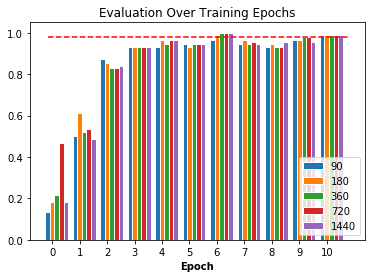

<Figure size 432x288 with 0 Axes>

In [16]:
plot_training_progress(stored_scores=stored_scores, test_range=test_range, num_saves=len(stored_scores) // len(test_range),
                       real_data_score=score_real, save=exp_name)

This looks pretty reasonable. It looks like our model peaked around epoch 6000 when trained on a larger amount of data. What did the accuracy come out to be when trained here?

In [17]:
np.max(stored_scores)

1.0

In [19]:
parse_models(stored_models=stored_models, epoch=6000, print_interval=print_interval, test_range=test_range,
             ind=3, x_test=x_test, y_test=y_test, labels=labels_list)

Accuracy: 1.0
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-09}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        24

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

[[29  0  0]
 [ 0 35  0]
 [ 0  0 24]]


Well, this is definitely an improvement.

### Visualizing model and training diagnostics
Let's take a look at some plots of our training to see if we can better understand what is happening here.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


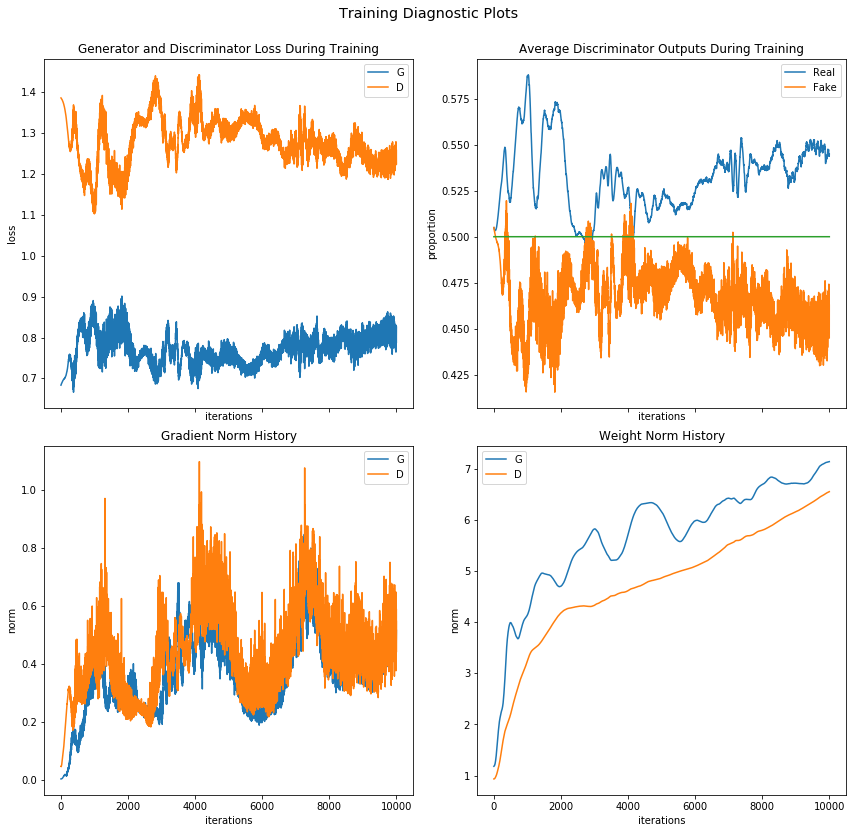

In [20]:
training_plots(netD=netD, netG=netG, num_epochs=num_epochs, save=exp_name)

Top left plot: Neither the generator nor discriminator are dominating here. This is a good sign.

Bottom left plot: The gradient norms of both networks do not appear to be converging to a small value. This could be a bad sign, but at least the gradients are not vanishing or exploding.

Top right plot: In an ideal scenario, the predictions of the discriminator would be 50/50 between outputting real and fakes. I'm not entirely sure how to best interpret what is occurring here, but perhaps it shows some insight into the way in which the discriminator is being fooled by the generated data.

Bottom right plot: The weight norms are increasing over time. I tried experimenting with some l2 regularization, but this resulted in worse performing generalization, as well as much more tightly clustered data.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


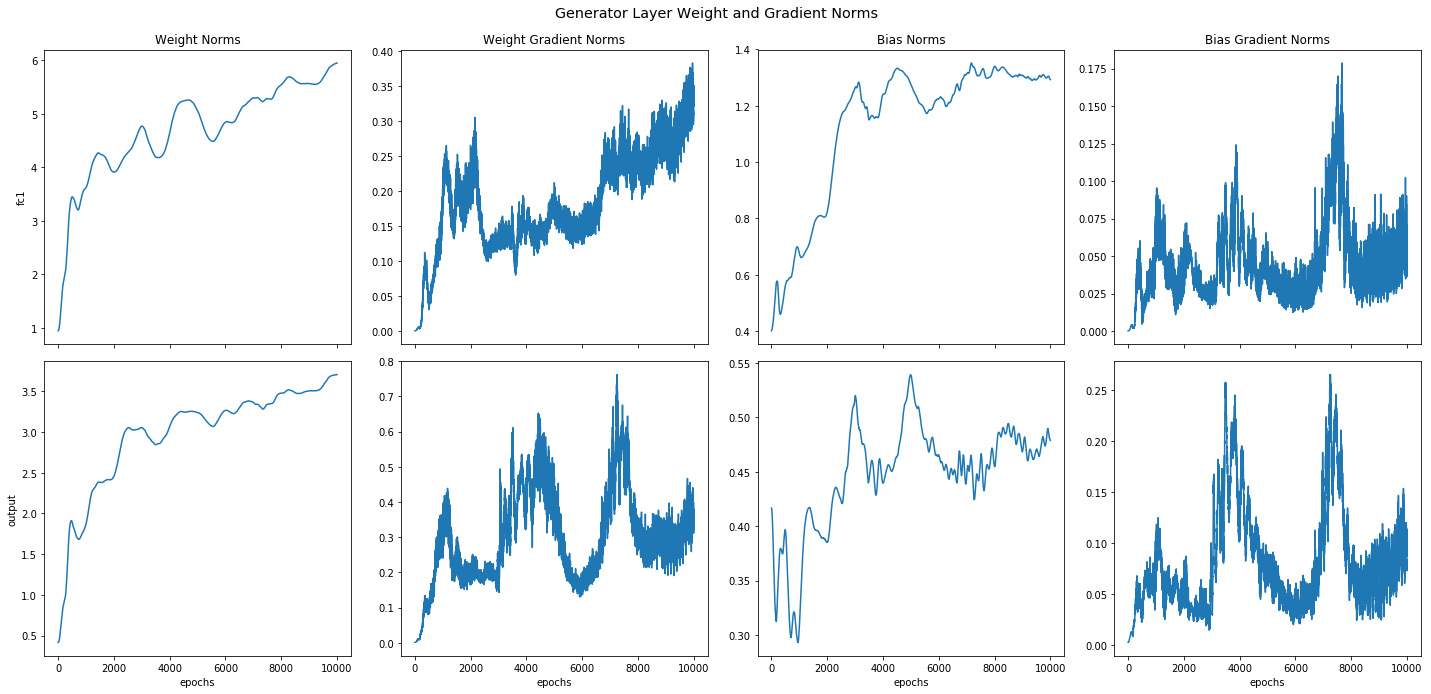

In [21]:
plot_layer_scatters(netG, title="Generator", save=exp_name)

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


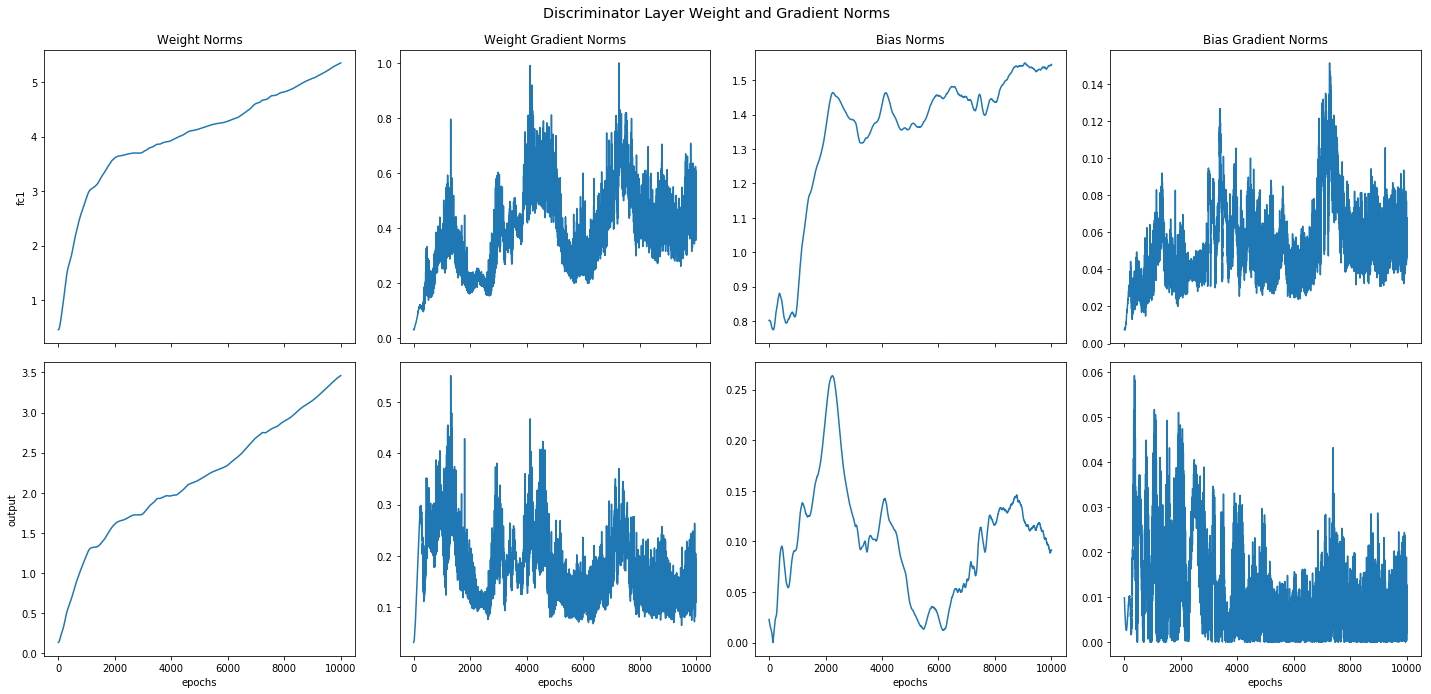

In [22]:
plot_layer_scatters(netD, title="Discriminator", save=exp_name)

These plots give a closer look into each layer and how training is behaving. They are interesting, but I don't feel there is much to say about what is happening here that isn't already gleaned from the initial training plot.

Let's use the best model saved from training earlier to generate a batch of fake data so we can compare against the real data

In [23]:
genned_data, genned_labels = gen_fake_data(netG=best_netG, bs=360, nz=nz, nc=nc, labels_list=labels_list, device=device)
model_fake, score_fake = train_test_logistic_reg(genned_data, genned_labels, x_test, y_test, param_grid=param_grid, cv=5, random_state=manualSeed, labels=labels_list)

Accuracy: 1.0
Best Parameters: {'C': 0.5, 'l1_ratio': 0, 'tol': 1e-09}
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        24

    accuracy                           1.00        88
   macro avg       1.00      1.00      1.00        88
weighted avg       1.00      1.00      1.00        88

[[29  0  0]
 [ 0 35  0]
 [ 0  0 24]]


/home/aj/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Let's visualize the scatter matrices of the real and fake data

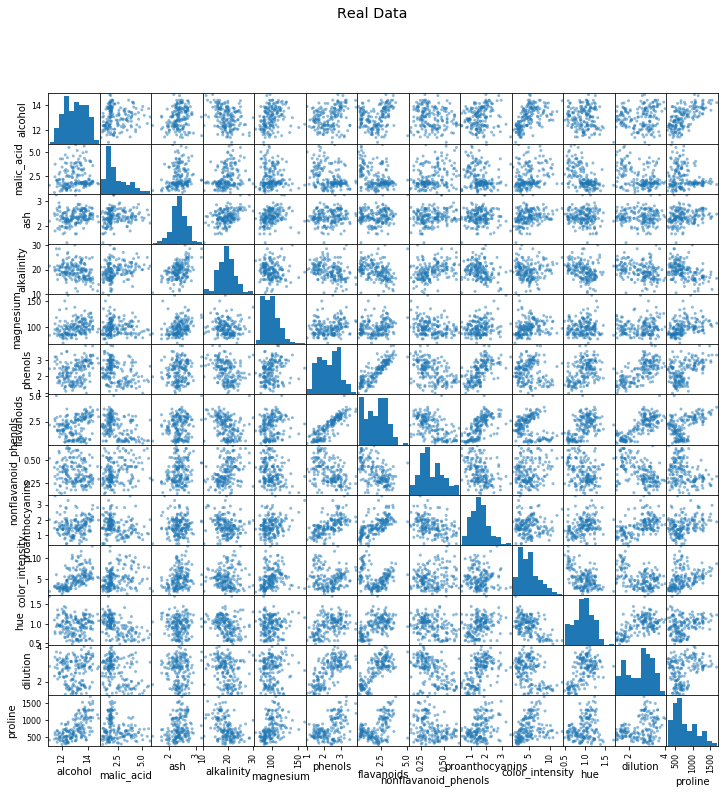

<Figure size 432x288 with 0 Axes>

In [24]:
plot_scatter_matrix(wine.drop(columns='class'), "Real Data", wine.drop(columns='class'), scaler=None, save=exp_name)

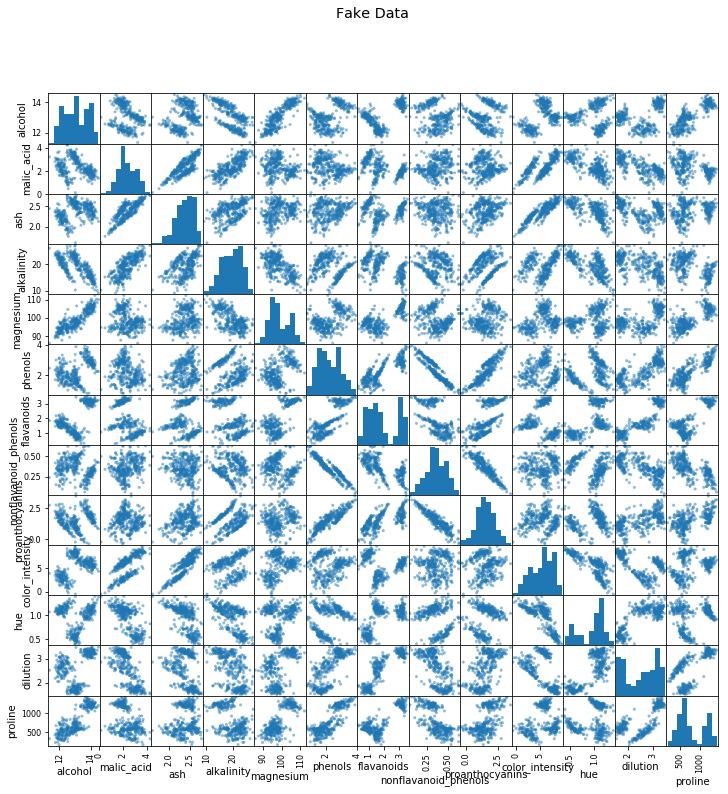

<Figure size 432x288 with 0 Axes>

In [25]:
plot_scatter_matrix(genned_data, "Fake Data", wine.drop(columns='class'), scaler=scaler, save=exp_name)

This is pretty interesting to try and interpret. It appears that the generator is being attracted to natural clusters in the data, which are more pronounced as the amount of generated data increases. My theory is that this is directly tied to the various wine classes. Let's look at some conditional distributions and see if that is the case. Dilution vs. Proline looks to be fairly pronounced.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


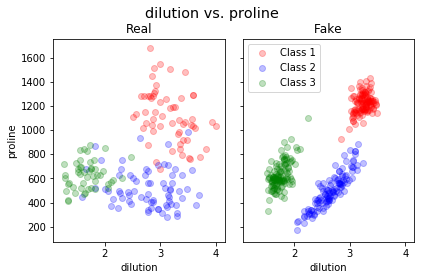

In [26]:
class_dict = {1: ('Class 1', 'r'),
              2: ('Class 2', 'b'),
              3: ('Class 3', 'g')}
plot_conditional_scatter(x_real=np.concatenate((x_train, x_test), axis=0),
                         y_real=np.concatenate((y_train, y_test), axis=0),
                         x_fake=genned_data,
                         y_fake=genned_labels,
                         col1=11,
                         col2=12,
                         class_dict=class_dict,
                         og_df=wine.drop(columns='class'),
                         scaler=scaler,
                         alpha=0.25,
                         save=exp_name)

It might also be interesting to check out the conditional density plots. Let's look at the one for Hue.

/home/aj/.local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


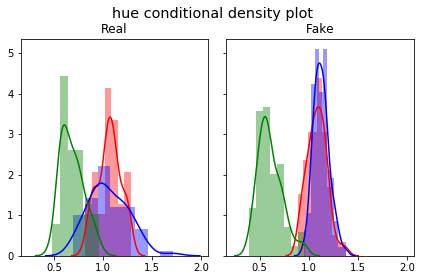

In [27]:
plot_conditional_density(x_real=np.concatenate((x_train, x_test), axis=0),
                         y_real=np.concatenate((y_train, y_test), axis=0),
                         x_fake=genned_data,
                         y_fake=genned_labels,
                         col=10,
                         class_dict=class_dict,
                         og_df=wine.drop(columns='class'),
                         scaler=scaler,
                         save=exp_name)

It appears that the GAN is producing values that are actually more diverse than the real data, which may be how it is generalizing better.